<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocess-for-MMvec" data-toc-modified-id="Preprocess-for-MMvec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocess for MMvec</a></span></li><li><span><a href="#Perform-paired-t-test-on-dietary-values" data-toc-modified-id="Perform-paired-t-test-on-dietary-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Perform paired t-test on dietary values</a></span><ul class="toc-item"><li><span><a href="#Analyze-more-samples" data-toc-modified-id="Analyze-more-samples-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analyze more samples</a></span></li></ul></li><li><span><a href="#Analyze-MMvec-results" data-toc-modified-id="Analyze-MMvec-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze MMvec results</a></span><ul class="toc-item"><li><span><a href="#Dietary-comparisons" data-toc-modified-id="Dietary-comparisons-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dietary comparisons</a></span></li><li><span><a href="#Microbial-comparisons" data-toc-modified-id="Microbial-comparisons-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Microbial comparisons</a></span></li></ul></li><li><span><a href="#Generate-microbe-diet-network" data-toc-modified-id="Generate-microbe-diet-network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate microbe-diet network</a></span></li><li><span><a href="#Simplified-dietary-figure" data-toc-modified-id="Simplified-dietary-figure-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simplified dietary figure</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
from scipy.stats import ttest_rel, ttest_ind

from adjustText import adjust_text

# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

Load taxonomies

In [2]:
taxonomy = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/ceph/wol2/wol2/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# Preprocess for MMvec

In [3]:
diaries = pd.read_excel(f'{berding_directory}/diet/ASD_All food diaries.xlsx', 
                        sheet_name='For SAS')
diaries = diaries.dropna(subset=['Subject$'])
diaries['Subject$'] = diaries['Subject$'].apply(lambda x: f'{int(x)}B')
baseline_diary = diaries.loc[diaries['timepoint$'] == 'baseline']
baseline_diary = baseline_diary.set_index('Subject$')
baseline_diary = baseline_diary.iloc[:, 9:]

# save dietary data to intermediate directory
from biom.util import biom_open
with biom_open(f'{berding_directory}/diet/diet.biom', 'w') as f:
    t = biom.Table(baseline_diary.values.T, baseline_diary.columns, baseline_diary.index)
    t.to_hdf5(f, 'diet')

# Perform paired t-test on dietary values

In [4]:
sample_metadata = pd.read_table(f'{berding_directory}/sample_metadata.txt', index_col=0)

baseline_diary = diaries.loc[diaries['timepoint$'] == 'baseline']
baseline_diary = baseline_diary.set_index('Subject$')
baseline_diary = baseline_diary.iloc[:, 9:]

baseline_diary_full = pd.merge(baseline_diary, sample_metadata, 
                               left_index=True, right_index=True)
# filter out incomplete matches
baseline_diary_full = baseline_diary_full.groupby("Match_IDs").filter(lambda x: len(x) == 2)
baseline_diary_full = baseline_diary_full.sort_values(['Match_IDs', 'Status'])

md = baseline_diary_full[['Match_IDs', 'Status']]

asd_diet = baseline_diary_full.loc[md.Status == 'ASD', baseline_diary.columns]
control_diet = baseline_diary_full.loc[md.Status == 'Control', baseline_diary.columns]

tres = ttest_rel(asd_diet.values.astype(np.float32), control_diet.values.astype(np.float32), axis=0)

diet_pvals = pd.Series(tres[1], index=baseline_diary.columns)
diet_tvals = pd.Series(tres[0], index=baseline_diary.columns)
diet_stats = pd.DataFrame({'tstat': diet_tvals, 'pval': diet_pvals})

## Analyze more samples

In [5]:
baseline_diary = diaries.loc[diaries['timepoint$'] == 'baseline']
baseline_diary = baseline_diary.set_index('Subject$')
dietary_cols = baseline_diary.columns[9:]

from q2_matchmaker._matching import _matchmaker
match_ids = _matchmaker(baseline_diary, 'Group$', ['age', 'Gender$'], [False, True])
match_ids = match_ids.dropna().astype(np.int64).apply(lambda x: f'BerdingDiet_{x}')
baseline_diary['Match_IDs'] = match_ids
baseline_diary = baseline_diary.dropna(subset=['Match_IDs'])

asd_diet = baseline_diary.loc[baseline_diary['Group$'] == 'ASD', dietary_cols]
control_diet = baseline_diary.loc[baseline_diary['Group$'] == 'Cont', dietary_cols]

tres = ttest_ind(asd_diet.values.astype(np.float32), 
                 control_diet.values.astype(np.float32), axis=0)
diet_pvals = pd.Series(tres[1], index=dietary_cols)
diet_tvals = pd.Series(tres[0], index=dietary_cols)
diet_stats = pd.DataFrame({'tstat': diet_tvals, 'pval': diet_pvals})
diet_stats = diet_stats.sort_values('tstat')

# Analyze MMvec results

In [6]:
from skbio import OrdinationResults
#ores = OrdinationResults.read(
#    f'{berding_directory}/diet/mmvec-ogu-latent10-results/'
#    'latent_dim_10_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ordination.txt')

ores = OrdinationResults.read(
    f'{berding_directory}/diet/mmvec-ogu-latent3-results-v2/'
    'latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ordination.txt')

## Dietary comparisons

In [7]:
from scipy.stats import pearsonr
for i in range(ores.samples.shape[1]):
    print(pearsonr(ores.samples[i], diet_tvals.loc[ores.samples.index]))

(0.31479554877709554, 0.0007654094130362812)
(-0.05380440286965298, 0.5748969812307507)
(0.2698553044384776, 0.004179892508293413)


Text(0, 0.5, 'Diet T-statistic')

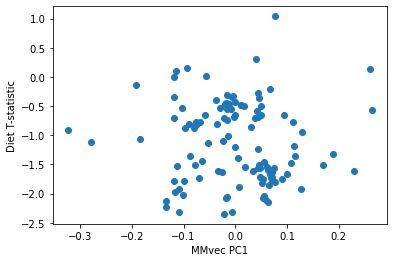

In [8]:
plt.scatter(ores.samples[1], diet_tvals.loc[ores.samples.index])
plt.xlabel('MMvec PC1')
plt.ylabel('Diet T-statistic')

## Microbial comparisons

In [9]:
# load 16S, whole genome shotgun and RNAseq data
#posterior_name = 'age_sex_matched_posterior'
#amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-v4.nc'
#amp_diffs = extract_differentials(amp_fname)
#amp_stats = ranking(amp_diffs, reference_percentile=90)

kang_directory = '../sfari/data/sra/Kang2017'
#amp_fname = f'../sfari/data/sra/Combined/age_sex_matched_posterior/amp_differentials-v5.nc'
amp_fname = f'../sfari/data/sra/Berding2020/age_sex_matched_posterior'

combined_amp_stats = pd.read_csv('../results/amp_combined_diffs.csv', index_col=0)
#amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
amp_diffs = extract_differentials(amp_fname)
amp_stats = ranking(amp_diffs, reference_percentile=50)

#amp_stats = pd.merge(amp_stats, taxonomy, left_index=True, right_index=True, how='left')
#amp_stats = amp_stats.set_index('GOTU')
taxa_cols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
amp_stats = pd.merge(amp_stats, combined_amp_stats[['group', 'Berding2020'] + taxa_cols], 
                     left_index=True, right_index=True, how='outer')

# create a consensus, focusing on microbes that agree between Berding and the combined analysis
def consensus_f(x):
    if x['Berding2020'] == x['group']:
        return x['group']
    return 'neutral'
amp_stats['Berding_group_consensus'] = amp_stats.apply(consensus_f, axis=1)

In [10]:
amp_stats['genus'].value_counts()

Bacteroides_E        64
Prevotella           38
Parabacteroides_B    34
Blautia_A            30
Alistipes_A          29
                     ..
GCA-900066905         1
Terrisporobacter      1
Mannheimia            1
Hafnia                1
CAG-217               1
Name: genus, Length: 377, dtype: int64

In [11]:
common_taxa = list(set(ores.features.index) & set(amp_stats.index))
amp_stats = amp_stats.loc[common_taxa]
for i in range(ores.features.shape[1]):
    print(pearsonr(ores.features.loc[common_taxa, i], 
                   amp_stats.loc[common_taxa, 'mean']))

(0.014490331272363021, 0.713171543335963)
(0.015541319290201892, 0.693385247351314)
(0.22841753866967668, 4.302026235389255e-09)


Text(0, 0.5, 'Microbial log fold change')

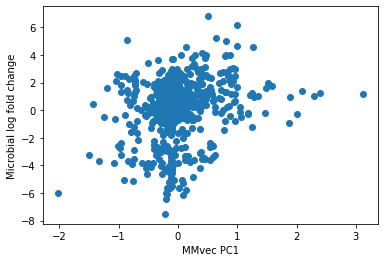

In [12]:
plt.scatter(ores.features.loc[common_taxa, 2], 
            amp_stats.loc[common_taxa, 'mean'])
plt.xlabel('MMvec PC1')
plt.ylabel('Microbial log fold change')

Takeaway, PC1 is very important - we should investigate it in more detail

In [13]:
amp_stats = amp_stats.sort_values('tstat')

# Generate microbe-diet network

In [14]:
!ls ../sfari/data/sra/Berding2020/diet/mmvec-ogu-latent10-results

latent_dim_10_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95
latent_dim_10_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_embedding.txt
latent_dim_10_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ordination.txt
latent_dim_10_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ranks.txt


In [15]:
#ranks = pd.read_table(
#    f'{berding_directory}/diet/mmvec-ogu-latent10-results/'
#    'latent_dim_10_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ranks.txt', 
#    index_col=0).T
ranks = pd.read_table(
    f'{berding_directory}/diet/mmvec-ogu-latent3-results-v2/'
    'latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ranks.txt',
    index_col=0).T
ranks = (ranks - ranks.mean(axis=0)) # clr center
microbes = ranks.index
diet_vars = ranks.columns

In [16]:
rankcoo = pd.melt(ranks.reset_index(), id_vars='index', var_name='DietCovariate')
rankcoo = rankcoo.loc[rankcoo['value'] > 0.1]
rankcoo = rankcoo.rename(columns={'index': 'microbe'})

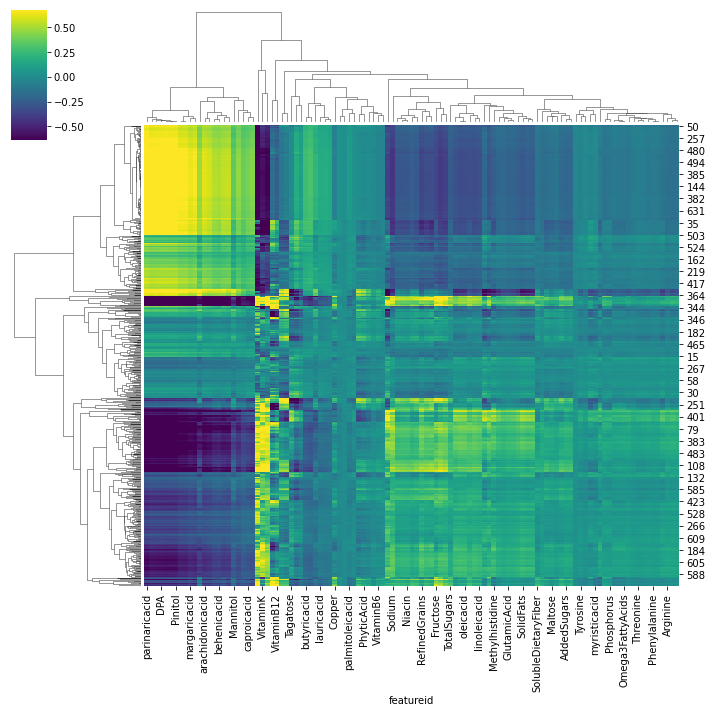

In [17]:
sns.clustermap(ranks.reset_index().iloc[:, 1:], cmap='viridis', robust=True)

In [18]:
import networkx as nx
diet_net = nx.from_pandas_edgelist(rankcoo, source='microbe', target='DietCovariate')
pos = nx.spring_layout(diet_net, k=1)
pos_df = pd.DataFrame(pos).T

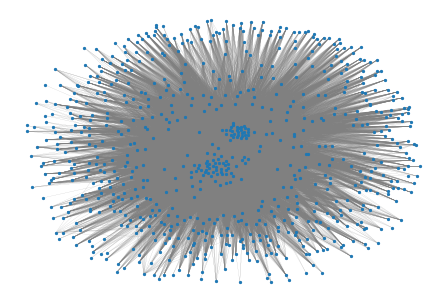

In [19]:
nx.draw(diet_net, pos=pos, node_size=5, width=0.1, edge_color='gray')

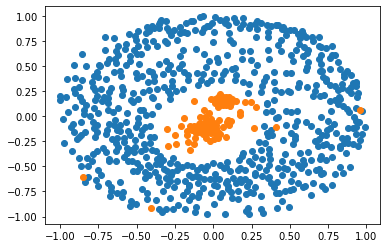

In [20]:
microbes = list(set(microbes) & set(pos_df.index))
diet_vars = list(set(diet_vars) & set(pos_df.index))

plt.scatter(pos_df.loc[microbes, 0], pos_df.loc[microbes, 1])
plt.scatter(pos_df.loc[diet_vars, 0], pos_df.loc[diet_vars, 1])

In [21]:
pos_df

,0,1
MJ006-2-barcode50-umi172706bins-ubs-3,0.318442,0.298713
TotalCarbohydrate,-0.006748,-0.081760
MJ006-1-barcode28-umi162137bins-ubs-3,-0.028956,0.546790
MJ006-1-barcode46-umi1213bins-ubs-45,-0.198540,0.267819
MJ006-2-barcode73-umi163376bins-ubs-3,0.381337,-0.192242
...,...,...
TotalGrains,-0.016344,-0.026731
WholeGrains,0.073824,0.178541
RefinedGrains,-0.055488,-0.054856
ALA,-0.189229,-0.020223


focus on significant taxa and dietary variables

In [22]:
diet_substats = diet_stats[diet_stats.pval < 0.1]

In [23]:
ranks

featureid,TotalCarbohydrate,TotalProtein,AnimalProtein,VegetableProtein,Cholesterol,SFA,MUFA,PUFA,Fructose,Galactose,...,CLA,CLAcis9trans11,CLAtrans10cis12,Tagatose,AddedSugarsTotalSugars,TotalGrains,WholeGrains,RefinedGrains,ALA,SolidFats
MJ006-2-barcode50-umi172706bins-ubs-3,0.663912,0.145788,0.022902,0.363813,0.144508,0.117522,0.243027,0.272507,0.400050,-0.116937,...,-0.466340,-0.488774,-0.605510,-0.190323,0.227938,0.205897,-0.315016,0.353905,0.053212,0.142629
MJ006-1-barcode28-umi162137bins-ubs-3,0.848356,0.074560,-0.088118,0.358821,-0.146726,0.038736,0.168205,0.195808,0.141398,0.048769,...,-0.298343,-0.317223,-0.408016,-0.230902,0.195903,0.239730,-0.271137,0.399722,0.092551,0.066292
MJ020-1-barcode30-umi109337bins-ubs-3,-0.076704,0.073649,0.119419,-0.002524,0.156987,0.092294,0.073018,0.054611,-0.012964,-0.066247,...,-0.076795,-0.082084,-0.110674,0.127685,-0.005579,-0.014673,-0.129717,0.026752,0.039539,0.095136
MJ006-1-barcode46-umi1213bins-ubs-45,0.723985,0.273745,0.223750,0.370908,0.434321,0.274608,0.373732,0.375890,0.429662,-0.249793,...,-0.627385,-0.659291,-0.828074,0.005926,0.229828,0.183204,-0.534865,0.398595,0.108828,0.304590
MJ006-2-barcode73-umi163376bins-ubs-3,0.158134,0.359585,0.514501,0.106239,0.697632,0.430915,0.388517,0.317513,0.042452,-0.311063,...,-0.472340,-0.502467,-0.663014,0.488584,0.044786,0.005538,-0.668584,0.237057,0.192907,0.451934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MJ006-2-barcode52-umi148100bins-ubs-4,0.381174,0.181005,0.184275,0.182517,0.310544,0.193014,0.230373,0.219907,0.202248,-0.164530,...,-0.359192,-0.378354,-0.480015,0.081777,0.110009,0.081873,-0.347694,0.215231,0.078817,0.209757
MJ005-barcode49-umi74120bins-ubs-4,-0.727778,-0.219887,-0.182695,-0.292866,-0.349876,-0.221715,-0.299188,-0.299641,-0.335242,0.201865,...,0.502366,0.528006,0.663578,-0.011280,-0.180256,-0.143553,0.434199,-0.317530,-0.088207,-0.245747
LC368255,-0.776857,-0.236718,-0.188228,-0.329887,-0.360752,-0.236656,-0.325736,-0.327699,-0.361118,0.209514,...,0.546496,0.574642,0.722923,0.000499,-0.201622,-0.165616,0.473748,-0.358589,-0.099074,-0.263614
G000156535,0.584151,0.265070,0.183831,0.415837,0.360602,0.257820,0.375862,0.384028,0.421128,-0.211754,...,-0.628611,-0.661502,-0.833492,-0.044131,0.252775,0.220423,-0.538733,0.449566,0.120528,0.290902


([], [])

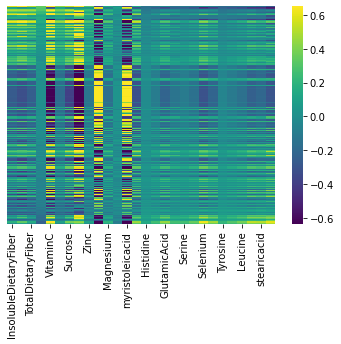

In [24]:
microbe_pc1 = ores.features[1].sort_values()
diet_pc1 = ores.samples[1].loc[diet_substats.index].sort_values()
sns.heatmap(ranks.loc[microbe_pc1.index, diet_pc1.index], robust=True,
            cmap='viridis')
plt.yticks([])

Get ASD specific taxa from meta-disease analysis

Plot dietary co-occurrence results

In [25]:
len(set(ores.features.index)), len(common_taxa), microbe_pc1.shape

(646, 646, (646,))

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 111.0)

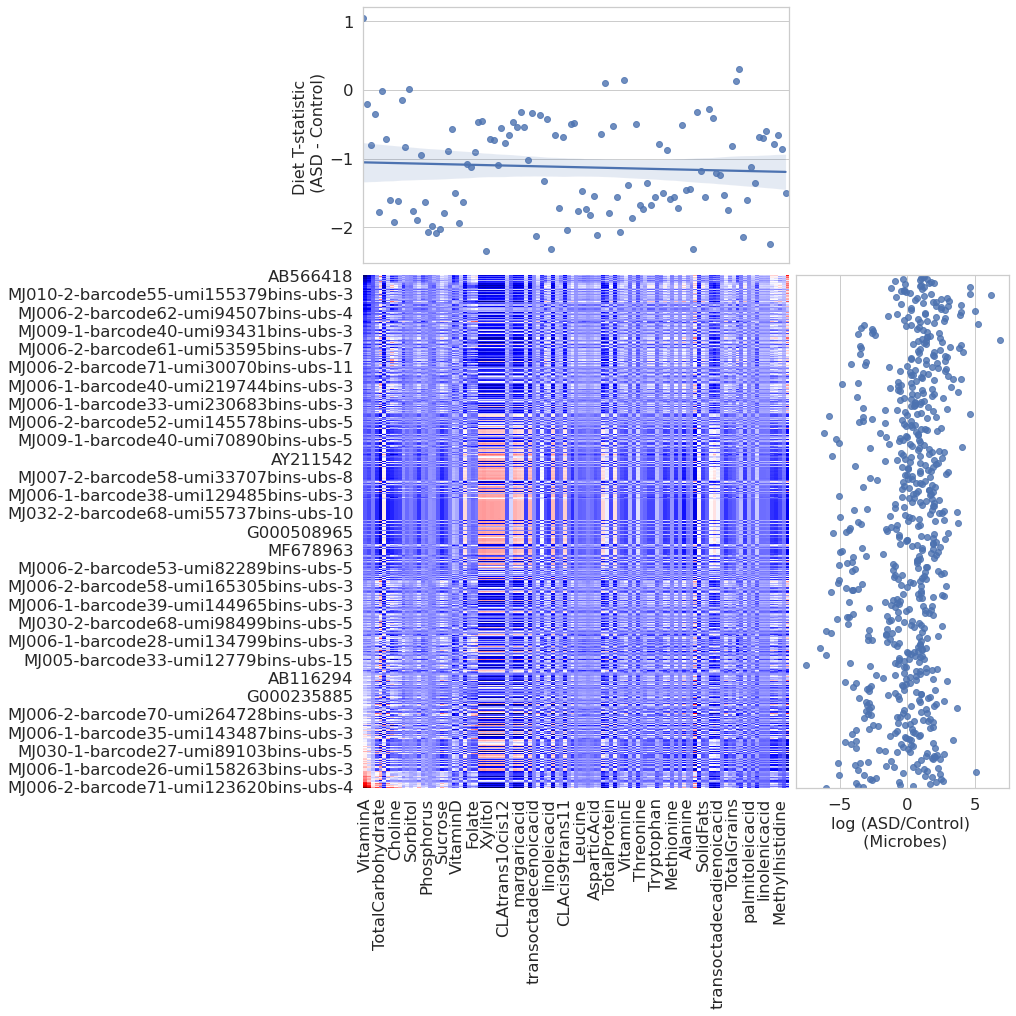

In [26]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

taxa_names = mapping.set_index('GOTU')['species']
common_taxa = list(set(ores.features.index) & set(amp_stats.index))
pc = 2
microbe_pc1 = ores.features.loc[common_taxa, pc].sort_values()
diet_pc1 = ores.samples[pc].sort_values()

lfc = amp_stats.loc[common_taxa, 'mean']
idx = ores.features.loc[common_taxa, pc].sort_values().index
lfc = lfc.loc[idx].sort_values()

#diet_stats = diet_stats.sort_values('tval')

fig = plt.figure(constrained_layout=True, figsize=(14, 14))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[1:, :2])
ax2 = fig.add_subplot(gs[1:, 2])
ax3 = fig.add_subplot(gs[0, :2])


#diet_substats = diet_stats[diet_stats.pval < 0.1]
#diet_pc1 = ores.samples[0].loc[diet_substats.index].sort_values()
#diet_pc1 = ores.samples[0].sort_values()

cranks = ranks.loc[microbe_pc1.index, diet_pc1.index]

#cranks = ranks.loc[lfc.index, diet_stats.index]

#cranks.index = list(map(lambda x: taxa_names.loc[x], microbe_pc1.index))

g = sns.heatmap(cranks.iloc[:, ::-1], robust=False, cbar=False,
                cmap='seismic', ax=ax1)
#ax1.set_yticklabels([])
#ax1.set_xticklabels([])


ax = ax2
sns.regplot(lfc.loc[microbe_pc1.index], np.arange(len(lfc)), ax=ax, fit_reg=False)

ax.set_yticks([])
ax.set_ylim([0, len(lfc)])

ax.set_xlabel('log (ASD/Control) \n (Microbes)', 
               fontsize=16)

ax = ax3

dtv = diet_tvals.loc[diet_pc1.index]
sns.regplot(np.arange(len(dtv)), dtv.iloc[::-1],  ax=ax)
ax.set_ylabel('Diet T-statistic \n (ASD - Control)', fontsize=16)
ax.set_xticks([])
ax.set_xlim([0, len(dtv)])

#plt.tight_layout()

In [27]:
common_taxa

['MJ006-1-barcode37-umi167776bins-ubs-3',
 'MJ006-1-barcode31-umi139678bins-ubs-5',
 'MJ020-1-barcode37-umi111719bins-ubs-3',
 'MJ006-1-barcode38-umi103398bins-ubs-4',
 'MJ005-barcode50-umi107842bins-ubs-3',
 'MJ006-1-barcode35-umi17034bins-ubs-14',
 'MJ005-barcode33-umi12779bins-ubs-15',
 'MJ006-1-barcode38-umi154953bins-ubs-3',
 'MJ005-barcode33-umi56723bins-ubs-5',
 'MJ005-barcode33-umi19895bins-ubs-10',
 'AB916502',
 'MJ006-2-barcode72-umi115382bins-ubs-4',
 'G004558915',
 'MJ006-1-barcode28-umi134799bins-ubs-3',
 'MJ006-2-barcode64-umi131324bins-ubs-4',
 'MJ006-2-barcode66-umi142467bins-ubs-3',
 'G000154805',
 'MJ030-1-barcode27-umi100851bins-ubs-3',
 'MJ006-1-barcode38-umi118150bins-ubs-4',
 'MJ006-1-barcode38-umi155082bins-ubs-3',
 'MJ009-1-barcode40-umi30023bins-ubs-12',
 'MJ006-1-barcode32-umi100692bins-ubs-4',
 'MJ006-1-barcode31-umi86567bins-ubs-5',
 'MJ006-1-barcode45-umi86683bins-ubs-5',
 'MJ009-1-barcode40-umi88628bins-ubs-3',
 'MJ006-1-barcode38-umi104566bins-ubs-4',
 'G

<ipython-input-28-0dbb5cb5d1f2>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  diet_stats['sig'] = (diet_stats['pval'] < 0.1).astype(np.bool)


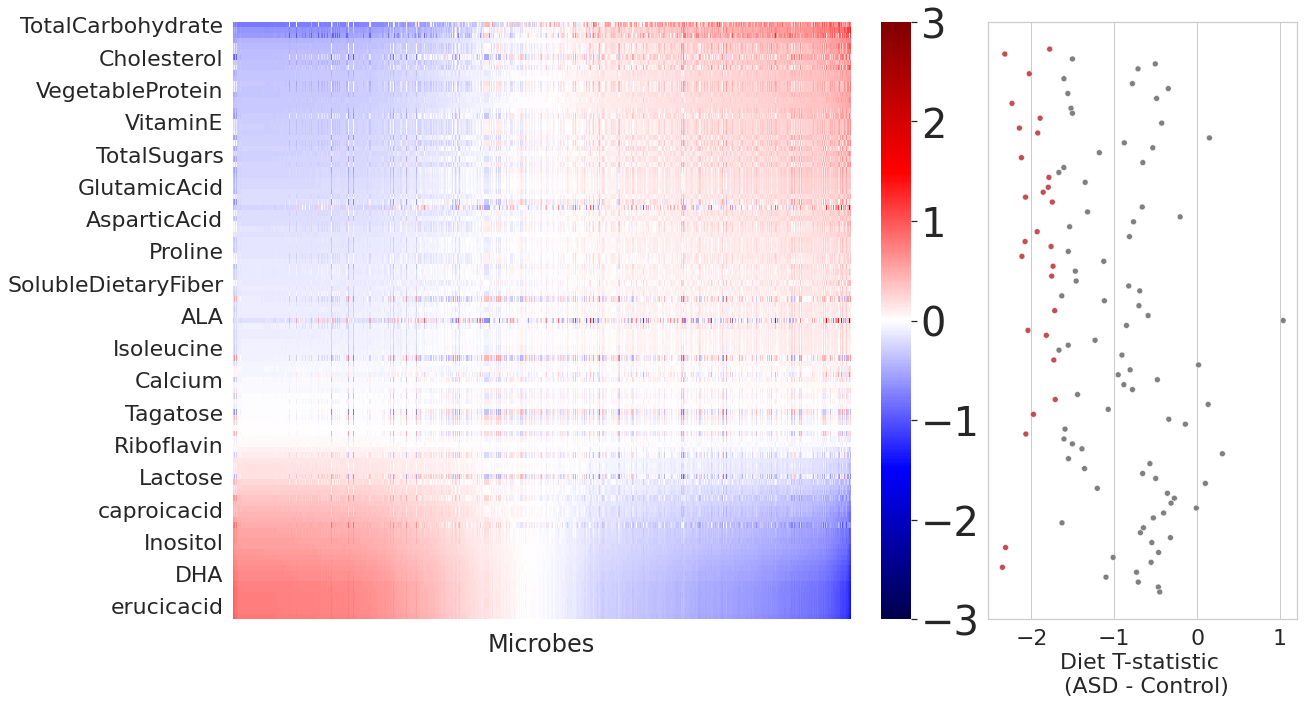

In [28]:
sns.set(font_scale=2)
sns.set_style('whitegrid')
#with plt.style.context('dark_background'):
ast = pd.read_csv('../results/amp-crossectional-studies.csv', index_col=0)
taxa_names = mapping.set_index('GOTU')['species']
#common_taxa = list(set(ores.features.index) & set(amp_stats.index) & set(ast.loc[ast['num_studies'] == 8].GOTU))
common_taxa = list(set(ores.features.index) & set(amp_stats.index))
pc = 0
microbe_pc1 = ores.features.loc[common_taxa, pc].sort_values()
diet_pc1 = ores.samples[pc].sort_values()

lfc = amp_stats.loc[common_taxa, 'mean']
idx = ores.features.loc[common_taxa, pc].sort_values().index
lfc = lfc.loc[idx].sort_values()

fig = plt.figure(constrained_layout=True, figsize=(18, 18))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[1:, :2])
ax2 = fig.add_subplot(gs[1:, 2])
#ax3 = fig.add_subplot(gs[0, :2])


#diet_substats = diet_stats[diet_stats.pval < 0.1]
#diet_pc1 = ores.samples[0].loc[diet_substats.index].sort_values()
#diet_pc1 = ores.samples[pc].sort_values()

cranks = ranks.loc[microbe_pc1.index, diet_pc1.index]
#cranks.index = list(map(lambda x: taxa_names.loc[x], microbe_pc1.index))

g = sns.heatmap(cranks.T.iloc[:, ::-1], robust=False, cbar=True,
                vmin=-3, vmax=3,
                cmap='seismic', ax=ax1)
ax1.set_xticklabels([])
ax1.set_xlabel('Microbes', fontsize=24)


ax = ax2
diet_stats = pd.DataFrame({'tval': diet_tvals, 'pval': diet_pvals})
diet_stats = diet_stats.loc[cranks.columns]
diet_stats['idx'] = np.arange(len(diet_stats))[::-1]
diet_stats['sig'] = (diet_stats['pval'] < 0.1).astype(np.bool)

sns.scatterplot(y='idx', x='tval', hue='sig', data=diet_stats, legend=False, 
                palette={True: 'r', False:'#808080'}, s=35)
ax.set_xlabel('Diet T-statistic \n (ASD - Control)', fontsize=22)
ax.set_yticks([])
ax.set_ylabel('')
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=40)

#ax.set_ylim([0, len(dtv)])

#plt.tight_layout()

Save supplemental figure

In [29]:
diet_table = cranks.T.copy()
diet_table = pd.merge(diet_stats[['tval', 'pval']], diet_table, 
                      left_index=True, right_index=True)
diet_table.to_csv('../results/supplemental_tables/Table_S15.csv')

In [30]:
diet_stats.sort_values('pval').head(20)

,tval,pval,idx,sig
Xylitol,-2.349415,0.023152,5,True
VitaminC,-2.320575,0.024798,109,True
myristoleicacid,-2.311589,0.025332,9,True
OxalicAcid,-2.234161,0.030374,99,True
Selenium,-2.144629,0.037298,94,True
InsolubleDietaryFiber,-2.120002,0.039431,88,True
Proline,-2.114018,0.039966,68,True
Magnesium,-2.076200,0.043491,71,True
GlutamicAcid,-2.070522,0.044043,80,True
Riboflavin,-2.066734,0.044415,32,True


In [31]:
print(', '.join(diet_stats.sort_values('pval').head(28).index))

Xylitol, VitaminC, myristoleicacid, OxalicAcid, Selenium, InsolubleDietaryFiber, Proline, Magnesium, GlutamicAcid, Riboflavin, Serine, Sucrose, Manganese, Pectins, Choline, Potassium, Nitrogen, Phenylalanine, TotalProtein, TotalDietaryFiber, TotalCarbohydrate, Leucine, PantothenicAcid, stearicacid, Zinc, Tyrosine, Valine, Histidine


<ipython-input-32-5a1d4515350d>:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_pos = np.vstack(pos.values())


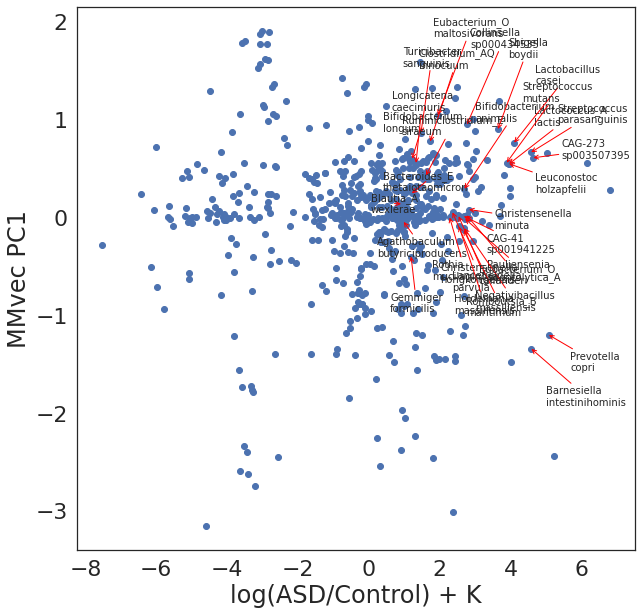

In [32]:
def repel_labels(ax, x, y, labels, k=0.01):
    """ Taken from https://stackoverflow.com/a/34697108/1167475"""
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        if label != '':
            ax.annotate(label,
                        xy=pos[data_str], xycoords='data',
                        xytext=pos[label], textcoords='data',
                        arrowprops=dict(arrowstyle="->",
                                        shrinkA=0, shrinkB=0,
                                        connectionstyle="arc3", 
                                        color='red'), fontsize=10)
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    #ax.set_xlim([mins[0], maxs[0]])
    #ax.set_ylim([mins[1], maxs[1]])
    return mins, maxs

sns.set_style('white')

m_pc1 = pd.merge(amp_stats, pd.DataFrame({'MMvec_PC1': ores.features[1]}), 
                 left_index=True, right_index=True, how='outer')

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y=m_pc1['MMvec_PC1'], x=m_pc1['mean'])
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

def label_f(x):
    if x['pvalue'] < 1e-50 and x['group'] == 'num' and x['Berding_group_consensus'] == 'num':
        if pd.isnull(x['species']):
            return ''
        if 'sp.' in x['species']:
            return x['species'].replace('sp.', 'sp.\n')
        return x['species'].replace(' ', '\n')
    else:
        return ''

labels = m_pc1.apply(label_f, axis=1)

mins, maxs = repel_labels(ax, y=m_pc1['MMvec_PC1'], x=m_pc1['mean'], labels=labels, k=0.3)
        
ax.set_xlabel('log(ASD/Control) + K')
ax.set_ylabel('MMvec PC1')

xs = m_pc1['mean']
ys = m_pc1['MMvec_PC1']
#ax.set_xlim([min(min(xs), mins[0]), max(max(xs), maxs[0]) + 1])
#ax.set_ylim([min(min(ys), mins[1]), max(max(ys), maxs[1]) + 1])

In [33]:
m_pc1.to_csv('../results/berding_diet_microbes.csv')

# Simplified dietary figure

In [34]:
pc = 3 # one based indexing
diet_stats[f'MMvec_PC{pc}'] = ores.samples[pc - 1]

m_pc1 = pd.merge(amp_stats, pd.DataFrame({f'MMvec_PC{pc}': ores.features[pc - 1]}), 
                 left_index=True, right_index=True)

bugs = ['Enterococcus', 'Bifidobacterium', 
        'Prevotella', 'Desulfovibrio', 'Bacteroides']


def genus_f(x):
    if pd.isnull(x):
        return 'Other'
    #if x.split('_')[0] == 'Enterococcus':
    #    return 'Enterococcus'
    if x.split('_')[0] == 'Desulfovibrio':
        return 'Desulfovibrio'
    if x.split('_')[0] == 'Bacteroides':
        return 'Bacteroides'
    
    if x in bugs:
        return x
    else:
        return 'Other'

m_pc1['genera'] = m_pc1['genus'].apply(genus_f)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/relational.py:650: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


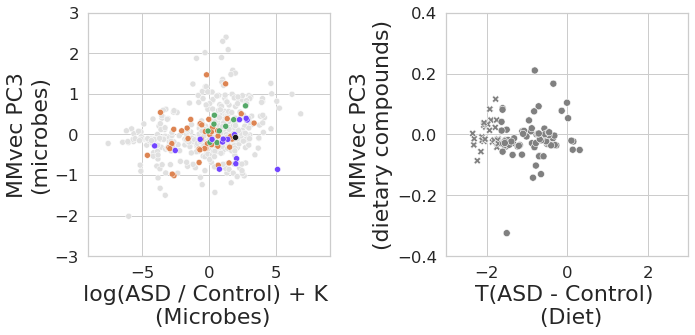

In [53]:
plt.rcParams['text.usetex'] = False

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#ast = pd.read_csv('../results/amp-crossectional.csv', index_col=0)
#ast = pd.merge(ast[['cluster_name', 'GOTU']], m_pc1, left_on='GOTU', right_index=True)

#plt.scatter(ores.samples[1], diet_tvals.loc[ores.samples.index])

# reorder for coloring
# idx =(m_pc1['Berding_group_consensus'] != 'neutral').sort_values().index
order = ['Other', 'Bifidobacterium', 'Bacteroides', 'Prevotella', 'Desulfovibrio']
bugs = ['Prevotella', 'Bacteroides', 'Bifidobacterium', 
        'Desulfovibrio']
palette = dict(zip(bugs, list(sns.color_palette())[:len(bugs)]))
palette['Other'] = '#E0E0E0'
palette['Prevotella'] = '#7245ff'
palette['Desulfovibrio'] = 'k'
# sort colors
m_pc1['ordering'] = m_pc1['genera'].apply(
    lambda x: {'Desulfovibrio': 1,  'Bifidobacterium': 3, 'Prevotella':3, 'Bacteroides': 4, 'Other': 5}[x])
m_pc1 = m_pc1.sort_values('ordering', ascending=False)
sns.scatterplot(data=m_pc1, x='mean', y=f'MMvec_PC{pc}', 
                hue='genera', 
                legend=False, 
                hue_order=order,
                palette=palette, 
                alpha=1,
                ax=ax[0])

sns.scatterplot(data=diet_stats, x='tval', y=f'MMvec_PC{pc}', style='sig', legend=False, 
                 ax=ax[1], color='gray', s=50)


#subset_taxa = ['Prevotella copri', 'Bifidobacterium longum', 
#'Bifidobacterium animalis',
#'Gemmiger formicilis', 'Shigella boydii',
#'Turicibacter sanguinis', 
#'Bacteroides_E thetaiotaomicron'
#              ]




"""
idx = m_pc1['species'].apply(lambda x: x in subset_taxa)
mm_pc1 = (m_pc1
          .loc[idx]
          .query('Berding_group_consensus == "num"')
          .query('group == "num"')
          .dropna()
         )
def fix_labels(x):
    return x.replace(' ', '\n')

#mins, maxs = repel_labels(ax[0], 
#                          y=list(mm_pc1[f'MMvec_PC{pc}']), 
#                          x=list(mm_pc1['mean']), 
#                          labels=list(map(fix_labels, mm_pc1['species'])),
#                          k=.3)
y = list(mm_pc1[r'MMvec_PC'+str(pc)]) 
x = list(mm_pc1['mean'])
labels = list(map(fix_labels, mm_pc1['species']))
texts = [ax[0].text(x[k], y[k], f"{labels[k]}", 
                    fontsize=14, ha='center', va='center', zorder=20, style='italic') 
         for k in range(len(x))]
adjust_text(texts, ax=ax[0])
"""
ax[1].set_xlabel('T(ASD - Control) \n (Diet)', fontsize=22)
ax[0].set_xlabel('log(ASD / Control) + K \n (Microbes)', fontsize=22)

ax[0].set_ylabel(r'MMvec PC'+str(pc) + '\n(microbes)', fontsize=22)
ax[1].set_ylabel(r'MMvec PC'+str(pc) + '\n(dietary compounds)', fontsize=22)

ax[0].set_xlim([-9, 9])
ax[0].set_ylim([-3, 3])

ax[1].set_ylim([-.4, .4])
ax[1].set_xlim([-3, 3])

plt.tight_layout()

In [43]:
diet_stats['tval'].sort_values()

Xylitol           -2.349415
VitaminC          -2.320575
myristoleicacid   -2.311589
OxalicAcid        -2.234161
Selenium          -2.144629
                     ...   
Mannitol           0.099685
Tagatose           0.133479
VitaminE           0.148831
lauricacid         0.305348
VitaminA           1.039077
Name: tval, Length: 111, dtype: float32

<AxesSubplot:xlabel='tval', ylabel='MMvec_PC3'>

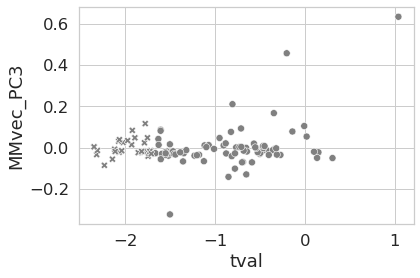

In [44]:
sns.scatterplot(data=diet_stats, x='tval', y=f'MMvec_PC{pc}', style='sig', legend=False, 
                color='gray', s=50)

In [ ]:
(m_pc1
 #.query("Berding_group_consensus == 'num'")
 .sort_values('MMvec_PC3')[['species', 'mean', 'pvalue', 'MMvec_PC3']]
 .dropna().head(50))

In [ ]:
(m_pc1
 #.query("Berding_group_consensus == 'denom'")
 .sort_values('MMvec_PC3')[['species', 'mean', 'pvalue', 'MMvec_PC3']]
 .dropna().tail(50))

In [ ]:
diet_stats.query('sig')

In [ ]:
m_pc1.query('mean > 0').query('pvalue < 1e-5').sort_values('pvalue')[['species', 'mean', 'pvalue']].dropna()

In [ ]:
print_cols = ['species', '5%', 'mean', '95%', 'pvalue', 'group', 'Berding_group_consensus']

In [ ]:
(m_pc1
 .query('mean > 0')
 .query('pvalue < 1e-5')
 .query('Berding_group_consensus == "num"')[print_cols]
 .sort_values('pvalue')
 .dropna()).head(10)

In [ ]:
m_pc1.query("Berding_group_consensus == 'num'").sort_values('pvalue')[['species', 'mean', 'pvalue']].dropna()

In [ ]:
sns.distplot(m_pc1['MMvec_PC3'])

In [ ]:
m_pc1['MMvec_PC3'].quantile([0.05, 0.25, 0.50, 0.75, 0.95])

In [ ]:
(m_pc1
 .query("Berding_group_consensus != 'num'")
 .sort_values('MMvec_PC3')[['species', '5%', 'mean', '95%', 'pvalue', 'MMvec_PC3']]
 .dropna()
 .query("`95%` < 0"))

In [ ]:
(m_pc1
 .query("Berding_group_consensus == 'num'")
 .sort_values('MMvec_PC3')[['species', '5%', 'mean', '95%', 'pvalue', 'MMvec_PC3']]
 .dropna()
 .query("`5%` > 0"))

In [ ]:
amp_stats['genus'].value_counts()

In [ ]:
amp_stats.query('genus == "Bacteroides_E"')

In [ ]:
ores.proportion_explained